In [31]:
from __future__ import print_function

In [264]:
import sys, csv, re
import numpy as np
import pandas as pd

from collections import defaultdict
import tensorflow as tf 
print("TensorFlow version: " + tf.__version__)

import keras 
import nltk
print("Keras version: " + keras.__version__)
import keras.backend as K
from keras.layers import Dense, GlobalAveragePooling1D, Embedding, AveragePooling1D, Flatten, concatenate
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize, sent_tokenize
from keras.utils import to_categorical

print("NLTK version: " + nltk.__version__)
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(10)

TensorFlow version: 2.0.0
Keras version: 2.3.1
NLTK version: 3.4.5


In [5]:
def mapped_text(x):
    x_new = []
    for i in range(len(x)):
        x_clean = clean_str(x[i])
        x_strip = strip_char(x_clean, character_list)
        x_new.append(x_strip)
    return x_new

In [6]:
def strip_char(text, list_char):
    newString = ""
    for i in range(len(text)):
        if text[i] in list_char:
            newString += text[i]
        else:
            newString += "a"  # replace character that not in the char list
    return newString

In [ ]:
strip_char("hello", character_list)

In [14]:
import re
character_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
                  's', 't', 'u', 'v', 'w', 'x', 'y', 'z',  '1', '2', '3', '4', '5', '6', '7', '8', '9', '0',
                  '-', ',', ';', '.', '!', '?', ':', '"', '`', '/', '\\', '|', '_', '@', '#', '$', '%', '^',
                  '&', '*', '~', "'", '+', '=', '<', '>', '(', ')', '[', ']', '{', '}', '\n', " "]


def clean_str(string):
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [15]:
def load_data(data_path):
    """
    data_path: location of the data file
    return: value(text) of data x to train and labels which were authors' names. 
            Labels are converted into numbers by Label Encoder. 
    """
   # load data 
    data = pd.read_csv(data_path, header=0)
    x = np.array(data['article'])
    y = np.array(data['class'])
    x_mapped = mapped_text(x)  # mapping with listed character
    
    # transform y (label of author name) into integer label (one hot vector)
    auth_class = list(set(y))
    le = preprocessing.LabelEncoder()
    le.fit(auth_class)
    y_numeric = le.transform(y)
    return np.array(x_mapped), np.array(y_numeric)

In [412]:
# C50/C50_train.csv or C10/C10_train.csv
x_train, y_train = load_data('C10/C10_train.csv')

In [55]:
def turn_to_integer(sequences, indices, mode):
    new_sequences = []
    for input_list in sequences:
        new_list = []
        if mode == 'word':
            for word in word_tokenize(input_list):
                if word in indices:
                    new_list.append(indices[word])
                else:
                    new_list.append(indices['unknown'])
            new_sequences.append(new_list)
        else:
            for character in input_list:
                if character in indices:
                    new_list.append(indices[character])
            new_sequences.append(new_list)
    return new_sequences


In [24]:
def create_ngram(input_list, n):
    return set(zip(*[input_list[i:] for i in range(n)]))

In [25]:
def add_ngram(sequences, token_indice, ngram_range, mode):
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        ngram_list = []
        if mode == 'word':
            ngram_list = new_list
        for i in range(len(new_list)-ngram_range+1):
            for ngram_value in range(2, ngram_range+1):
                ngram = tuple(new_list[i:i+ngram_value])
                if ngram in token_indice:
                    ngram_list.append(token_indice[ngram])
        new_sequences.append(ngram_list)
    return new_sequences

In [286]:
# average length of sentence
def average_sentence_length(doc):
    sent_tokenized = sent_tokenize(doc)
    average_sent_len = sum(len(sent) for sent in sent_tokenized)
    return average_sent_len
def average_nwords(doc):  # per sentence
    total_nwords = len(word_tokenize(doc))
    total_nsents = len(sent_tokenize(doc))
    return total_nwords/total_nsents # total number of words / total number of sentences
def average_word_len(doc):  # per sentence
    word_tokenized = word_tokenize(doc)
    total_word_len = sum(len(word) for word in word_tokenized)
    total_nwords = len(word_tokenized)
    return total_word_len/total_nwords # total length of words / total_nwords
def average_ncharacters(doc):  # average number of characters in a sentence
    total_ncharacters = sum(len(word) for word in word_tokenize(doc))
    total_sentence_len = len(sent_tokenize(doc))
    return total_ncharacters/total_sentence_len  # total number of characters / total number of sentences 
def freq_ndigits(doc):  # proportion of the use of digits in a document
    return sum(d.isdigit() for d in doc)/len(doc)
def ratio_hapax_legomenon(doc): # per document 
    word_indoc = word_tokenize(doc)
    fdist = nltk.FreqDist(word_indoc)
    fdist_hapx = nltk.FreqDist.hapaxes(fdist)
    return len(fdist_hapx)/len(word_indoc)
def letter_freq(doc):
    letter_indoc = ''.join([c for c in doc if c.isalpha()])
    letter = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's'
              , 't', 'u', 'v', 'w', 'x', 'y', 'z']
    count = dict()
    letter_freq = dict()
    for li in letter_indoc:
        if li in count.keys():
            count[li] += 1
        else:
            count[li] = 1
    for l in letter:
        if l in count.keys():
            letter_freq[l] = count[l]
        else: 
            letter_freq[l] = 0
    return np.array([*letter_freq.values()])
    

def create_feature(x_train):
    lexical_feature_all = []

    for doc in x_train:
        lexical_feature = []
        lexical_feature.append(average_sentence_length(doc))
        lexical_feature.append(average_nwords(doc))
        lexical_feature.append(average_word_len(doc))
        lexical_feature.append(average_ncharacters(doc))
        lexical_feature.append(freq_ndigits(doc))
        lexical_feature.append(ratio_hapax_legomenon(doc))
        lexical_feature.extend(letter_freq(doc))

        lexical_feature_all.append(lexical_feature)

    return lexical_feature_all


In [97]:
def input_rep(ngram_range, indices, maxlen, tr, vl, ts, mode):
    tr = turn_to_integer(tr, indices, mode)
    vl = turn_to_integer(vl, indices, mode)
    ts = turn_to_integer(ts, indices, mode)
    max_features = len(indices)
    if ngram_range > 1:
        print('Adding {}-gram features'.format(ngram_range))
        ngram_set = set()
        for input_list in tr:
            for i in range(2, ngram_range+1):
                ngrams = create_ngram(input_list, ngram_value=i)
                ngram_set.update(ngrams)
        start_index = max_features + 1
        token_indice = {v: k+start_index for k, v in enumerate(ngram_set)}
        indice_token = {token_indice[k]: k for k in token_indice}
        max_features = np.max(list(indice_token.keys())) + 1
        tr = add_ngram(tr, token_indice, ngram_range, mode)
        vl = add_ngram(vl, token_indice, ngram_range, mode)
        ts = add_ngram(ts, token_indice, ngram_range, mode)
    print('Pad sequences')
    tr = pad_sequences(tr, maxlen=maxlen)
    vl = pad_sequences(vl, maxlen=maxlen)
    ts = pad_sequences(ts, maxlen=maxlen)
    return tr, vl, ts, max_features


In [27]:
def eval(y_pred, y_ts):
    acc = accuracy_score(y_pred, y_ts)
    return acc

In [227]:
def single_model(train, 
              valid, 
              test, 
              y_tr, 
              y_val, 
              y_test, 
              max_features, 
              nb_class, 
              hidden_layer, 
              seq_length, 
              nb_epoch, 
              batch_size, 
              lr):

    model = Sequential()
    model.add(Embedding(max_features, output_dim=hidden_layer, input_length=seq_length, dropout=0.75, init='glorot_uniform'))
    model.add(AveragePooling1D(pool_length=model.output_shape[1]))
    model.add(Flatten())
    model.add(Dense(nb_class, activation='softmax'))
    adam = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')
    print ("Training the model...")
    hist = model.fit(train, y_tr,
                  nb_epoch=nb_epoch,
                  batch_size=batch_size,
                  validation_data=[valid, y_val],
                  callbacks=[earlystop_cb])
    fitted_model = model
    print ("Evaluate on test data..")
    loss, acc = model.evaluate(test, y_test, verbose=2)
    # predicted classes
    pred = model.predict_classes(test)
    return hist, acc, pred, fitted_model

In [396]:
def merged_model(train_char, 
              valid_char, 
              test_char, 
              train_wd, 
              valid_wd, 
              test_wd, 
              y_tr, 
              y_val, 
              y_test, 
              max_features_char, 
              max_features_wd,
              nb_class, 
              hidden_layer,
              seq_length_word, 
              seq_length_char, 
              nb_epoch, 
              batch_size, 
              lr):
    
    # 모형 클래스 객체 생성 
    # Create model
    modelw = Sequential()
    # Create Layers
    modelw.add(Embedding(max_features_wd, hidden_layer, input_length=seq_length_word, dropout=0.75, init='glorot_uniform'))
    modelw.add(AveragePooling1D(pool_length=modelw.output_shape[1]))
    modelw.add(Flatten())

    modelc = Sequential()
    modelc.add(Embedding(max_features_char, hidden_layer, input_length=seq_length_char, dropout=0.75, init='glorot_uniform'))
    modelc.add(AveragePooling1D(pool_length=modelc.output_shape[1]))
    modelc.add(Flatten()) 
    
    #Merge two models
    model = Sequential()
    merged_layer = concatenate([modelw.output, modelc.output], axis=1)
    merged_layer = Dense(nb_class, activation='softmax')(merged_layer)
    model= Model(inputs=[modelw.input, modelc.input], outputs=merged_layer)
    
    adam = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto') 
    print ("Training the model...")
    # 트레이닝 시작
    # Start to train - save the fitting history into hist
    hist = model.fit([train_wd, train_char], y_tr,
                      nb_epoch=nb_epoch,
                      batch_size=batch_size,
                      validation_data=([valid_wd,valid_char], y_val),
                      callbacks=[earlystop_cb])
    
    fitted_model = model
    print ("Evaluate on test data...")
    loss, acc = model.evaluate([test_wd, test_char], y_test, verbose=2)
    # predicted values 
    pred = model.predict([test_wd, test_char])

    return hist, acc, pred, fitted_model

In [447]:
def train_test(x_tr, x_val, x_ts, y_tr, y_val, y_ts,
               mode, mini_batch_size, nb_class, nb_epoch,
               seq_length_word, seq_length_char, lr):
    # turn the class label into categorical
    y_tr = to_categorical(y_tr)
    y_val = to_categorical(y_val)
    y_ts = to_categorical(y_ts)

    # create vocabulary for word
    word_vectorizer = CountVectorizer(analyzer='word', max_features=700, max_df=0.95, min_df=2, ngram_range=(1,1))
    wrd = word_vectorizer.fit(x_tr)
    wrd.vocabulary_['unknown'] = 0
    vocab = wrd.vocabulary_.keys()
    word_indices = dict((c, i) for i, c in enumerate(vocab))

    # create vocabulary for character
    chars = character_list
    char_indices = dict((c, i) for i, c in enumerate(chars))

    acc = 0
    # can change ngram range
    ngram_range_word = 2
    ngram_range_char = 4

    # represent the input and train test the model
    if mode == 'word':
        train, valid, test, max_features = input_rep(ngram_range_word, word_indices, seq_length_word, x_tr, x_val, x_ts, mode)
        acc = single_model(train, valid, test, y_tr, y_val, y_ts, max_features, nb_class, hidden_layer, seq_length_word, nb_epoch, batch_size, lr)

    elif mode == 'char':
        train, valid, test, max_features = input_rep(ngram_range_char, char_indices, seq_length_char, x_tr, x_val, x_ts, mode)
        acc = single_model(train, valid, test, y_tr, y_val, y_ts, max_features, nb_class, hidden_layer, seq_length_char, nb_epoch, batch_size, lr)

    elif mode == 'wordnchar':
        train_word, valid_word, test_word, max_features_word = input_rep(ngram_range_word, word_indices, seq_length_word, x_tr, x_val, x_ts, "word")
        train_char, valid_char, test_char, max_features_char = input_rep(ngram_range_char, char_indices, seq_length_char, x_tr, x_val, x_ts, "char")
        acc = merged_model(train_char, valid_char, test_char, train_word, valid_word, test_word,
                              y_tr, y_val, y_ts, max_features_char, max_features_word,
                              nb_class, hidden_layer, seq_length_word, seq_length_char, nb_epoch, batch_size, lr)
    return acc


In [439]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=50)

In [414]:
# C50/C50_test.csv 
# C10/C10_test.csv
x_ts, y_ts = load_data('C50/C50_test.csv')

In [440]:
nb_class = 50

mini_batch_size = 5
hidden_layer = 100
nb_epoch = 150
length_word = 1000
length_char = 9000
lr = 0.001

In [464]:
mode = 'word'
# mode = 'char'
# mode = 'wordnchar'
hist, acc, pred, model = train_test(x_tr, x_val, x_ts, y_tr, y_val, y_ts, mode, mini_batch_size, nb_class, nb_epoch,
                             length_word, length_char, lr)


Pad sequences (samples x time)
Adding 4-gram features
Pad sequences (samples x time)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(701, 100, input_length=1000, embeddings_initializer="glorot_uniform")`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(pool_size=1000)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Embedding` call to the Kera

Training the model...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2250 samples, validate on 250 samples
Epoch 1/150
2250/2250 [==============================] - 66s 29ms/step - loss: 3.8779 - accuracy: 0.0618 - val_loss: 3.8061 - val_accuracy: 0.1080
Epoch 2/150
2250/2250 [==============================] - 62s 28ms/step - loss: 3.6971 - accuracy: 0.1836 - val_loss: 3.6088 - val_accuracy: 0.1560
Epoch 3/150
2250/2250 [==============================] - 63s 28ms/step - loss: 3.4088 - accuracy: 0.3044 - val_loss: 3.3110 - val_accuracy: 0.2600
Epoch 4/150
2250/2250 [==============================] - 62s 28ms/step - loss: 3.0436 - accuracy: 0.4107 - val_loss: 2.9771 - val_accuracy: 0.3840
Epoch 5/150
2250/2250 [==============================] - 72s 32ms/step - loss: 2.6654 - accuracy: 0.4871 - val_loss: 2.6511 - val_accuracy: 0.4720
Epoch 6/150
2250/2250 [==============================] - 67s 30ms/step - loss: 2.3201 - accuracy: 0.5676 - val_loss: 2.3468 - val_accuracy: 0.5080
Epoch 7/150
2250/2250 [==============================] - 68s 30ms/step 

2250/2250 [==============================] - 58s 26ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.4027 - val_accuracy: 0.8840
Epoch 00056: early stopping
Evaluate on test data...


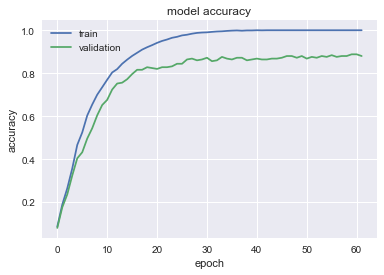

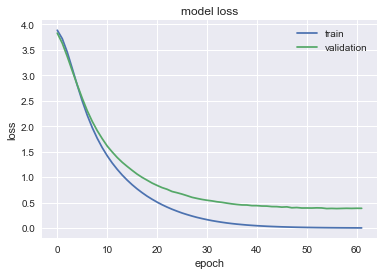

In [458]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()



In [459]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history) 

# or save to csv: 
hist_csv_file = 'history.csv'

with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [460]:
model.summary()

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_81 (Embedding)     (None, 9000, 100)         9158400   
_________________________________________________________________
average_pooling1d_80 (Averag (None, 1, 100)            0         
_________________________________________________________________
flatten_79 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 50)                5050      
Total params: 9,163,450
Trainable params: 9,163,450
Non-trainable params: 0
_________________________________________________________________


In [346]:
target_names_10 = ['AlanCrosby',
 'AlexanderSmith',
 'BenjaminKangLim',
 'DavidLawder',
 'JaneMacartney',
 'JimGilchrist',
 'MarcelMichelson',
 'MureDickie',
 'RobinSidel',
 'ToddNissen']

target_names_50 = ['AaronPressman',
 'AlanCrosby',
 'AlexanderSmith',
 'BenjaminKangLim',
 'BernardHickey',
 'BradDorfman',
 'DarrenSchuettler',
 'DavidLawder',
 'EdnaFernandes',
 'EricAuchard',
 'FumikoFujisaki',
 'GrahamEarnshaw',
 'HeatherScoffield',
 'JanLopatka',
 'JaneMacartney',
 'JimGilchrist',
 'JoWinterbottom',
 'JoeOrtiz',
 'JohnMastrini',
 'JonathanBirt',
 'KarlPenhaul',
 'KeithWeir',
 'KevinDrawbaugh',
 'KevinMorrison',
 'KirstinRidley',
 'KouroshKarimkhany',
 'LydiaZajc',
 "LynneO'Donnell",
 'LynnleyBrowning',
 'MarcelMichelson',
 'MarkBendeich',
 'MartinWolk',
 'MatthewBunce',
 'MichaelConnor',
 'MureDickie',
 'NickLouth',
 'PatriciaCommins',
 'PeterHumphrey',
 'PierreTran',
 'RobinSidel',
 'RogerFillion',
 'SamuelPerry',
 'SarahDavison',
 'ScottHillis',
 'SimonCowell',
 'TanEeLyn',
 'TheresePoletti',
 'TimFarrand',
 'ToddNissen',
 'WilliamKazer']


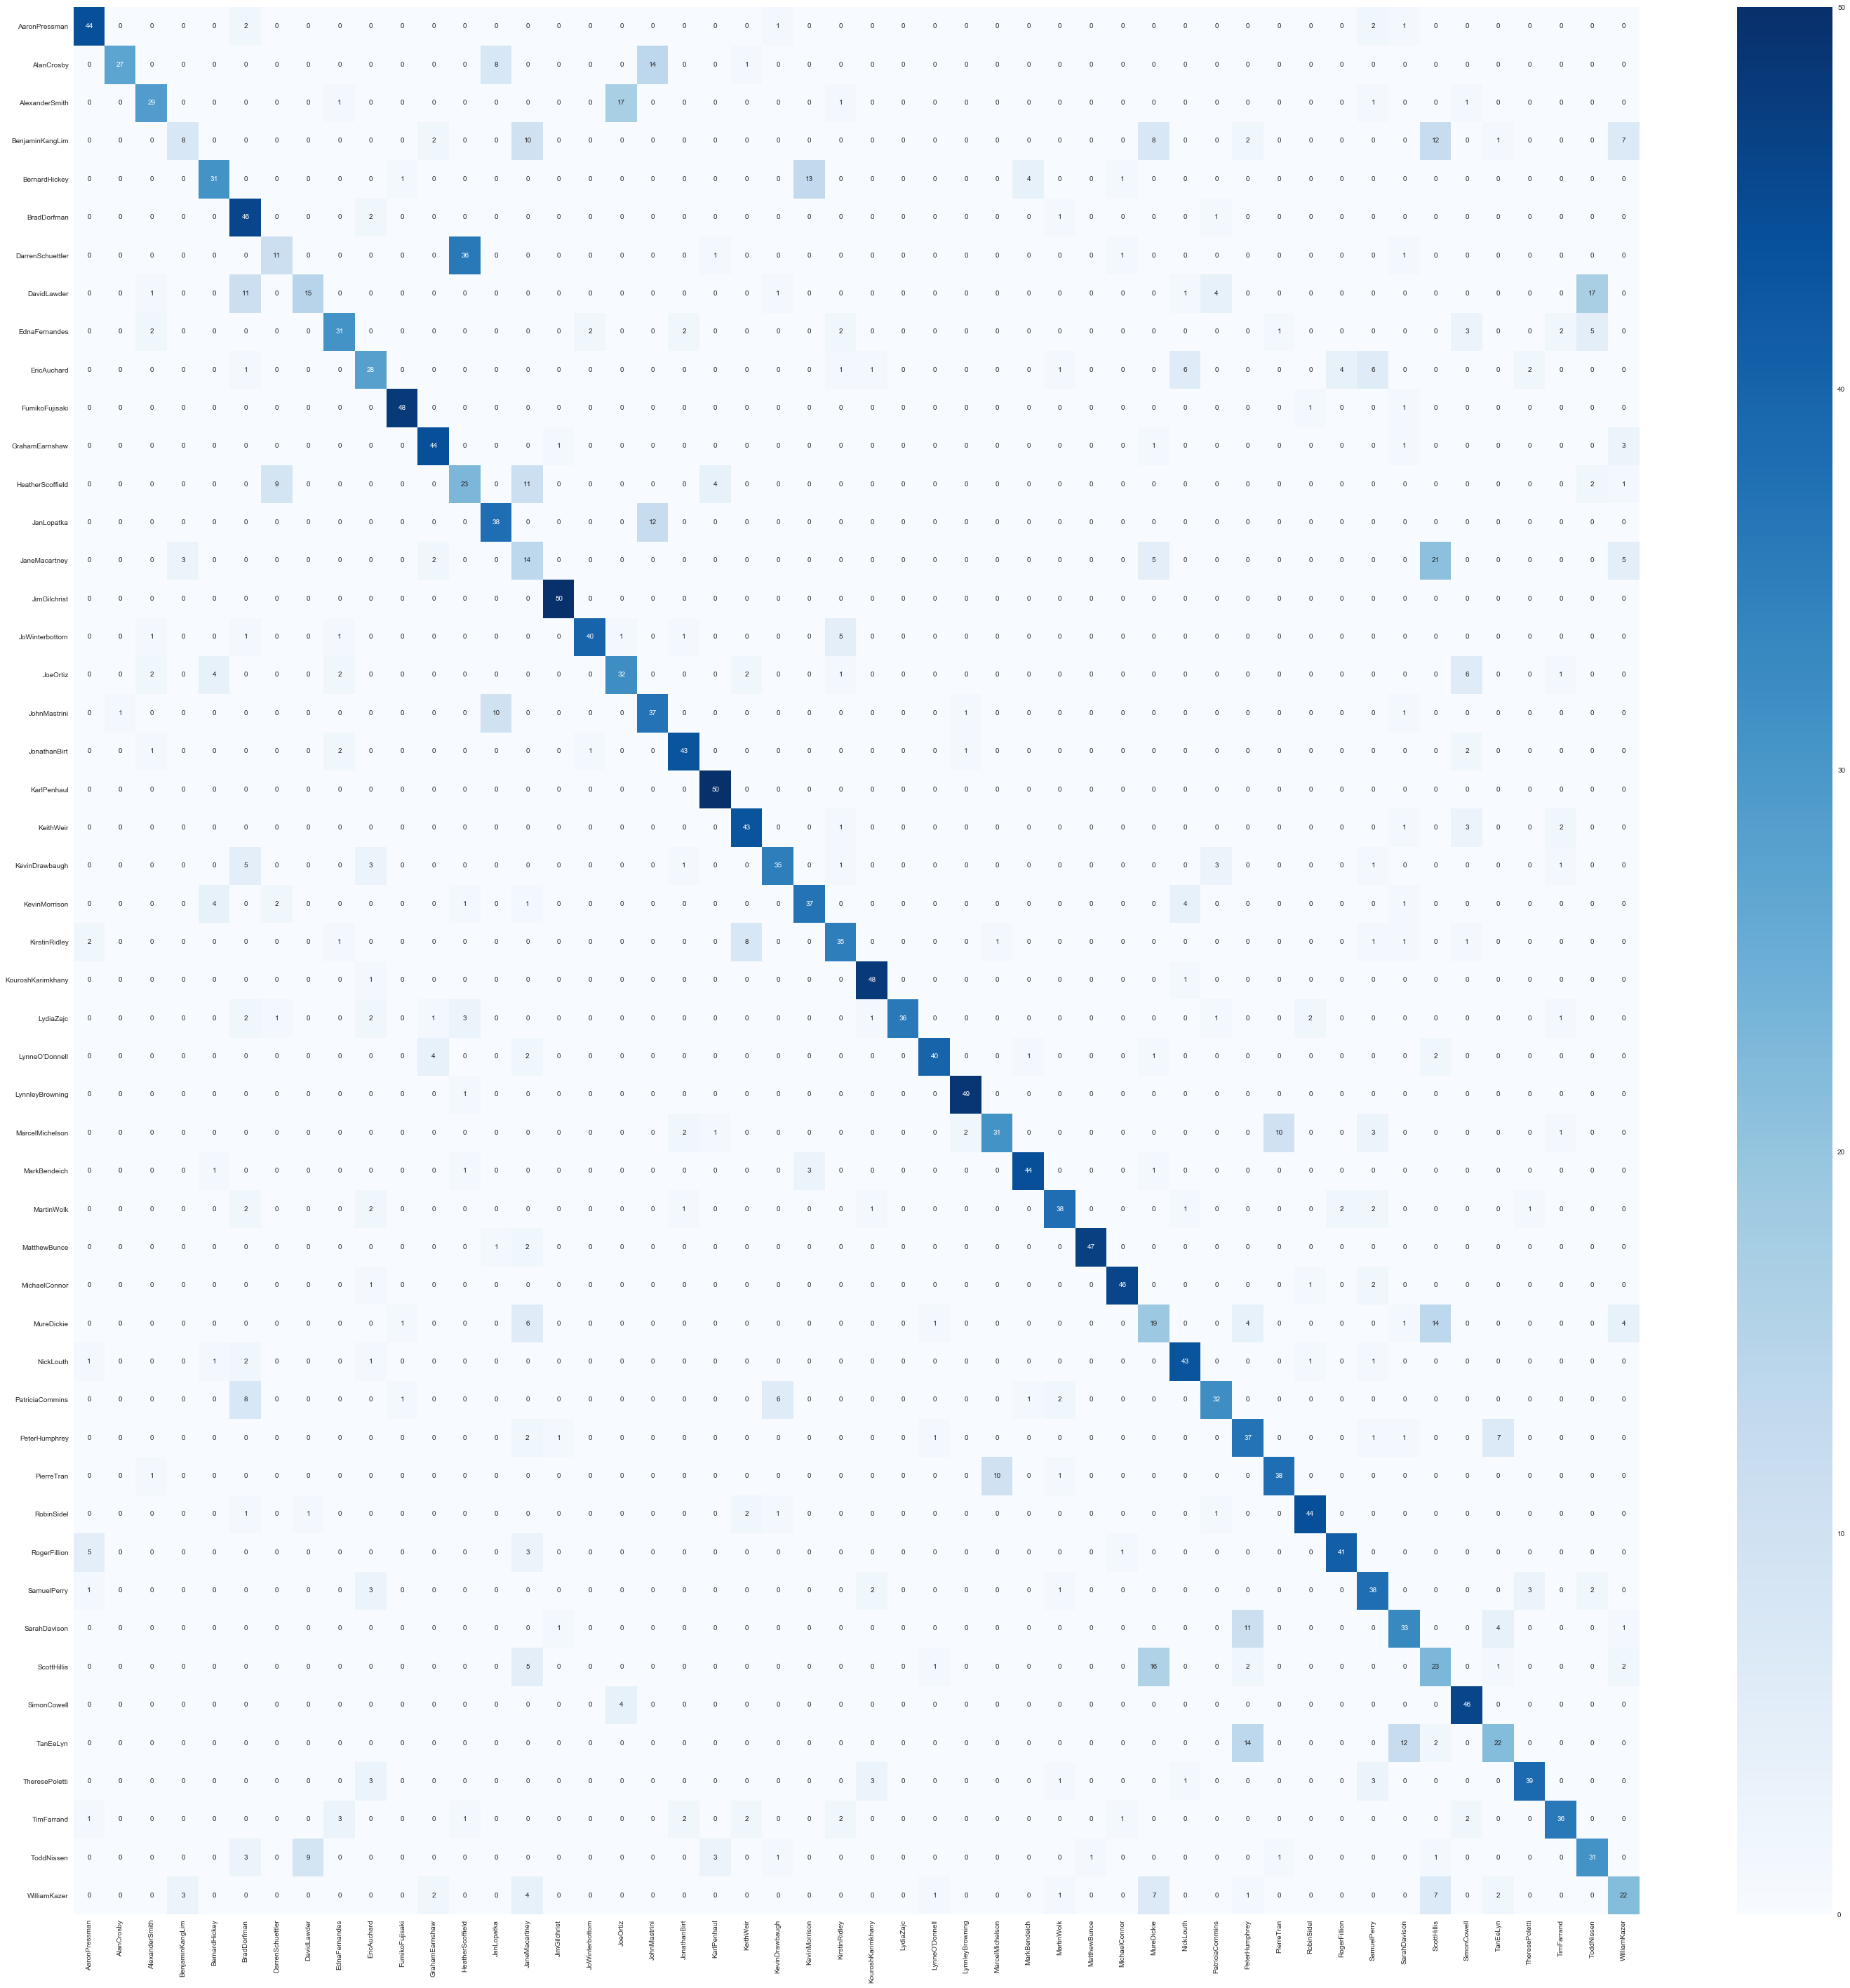

In [461]:
import seaborn as sns
# Need to uncomment below for the word and char n-gram (merged layers)
# pred = np.argmax(model,axis=1)
con_mat_df =  confusion_matrix(y_ts, pred)

###CCAT50###
# con_mat_df = pd.DataFrame(con_mat_df, index = [i for i in target_names_50],
#                                               columns =[i for i in target_names_50])
# plt.figure(figsize=(50,50))

###CCAT10###
con_mat_df = pd.DataFrame(con_mat_df, index = [i for i in target_names_10],
                                              columns =[i for i in target_names_10])
plt.figure(figsize=(10,10))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)

In [457]:
from sklearn.metrics import classification_report
classification_report(y_ts, pred, target_names=target_names_10)

"                   precision    recall  f1-score   support\n\n    AaronPressman       0.81      0.88      0.85        50\n       AlanCrosby       0.96      0.54      0.69        50\n   AlexanderSmith       0.78      0.58      0.67        50\n  BenjaminKangLim       0.57      0.16      0.25        50\n    BernardHickey       0.76      0.62      0.68        50\n      BradDorfman       0.55      0.92      0.69        50\n DarrenSchuettler       0.48      0.22      0.30        50\n      DavidLawder       0.60      0.30      0.40        50\n    EdnaFernandes       0.76      0.62      0.68        50\n      EricAuchard       0.61      0.56      0.58        50\n   FumikoFujisaki       0.94      0.96      0.95        50\n   GrahamEarnshaw       0.80      0.88      0.84        50\n HeatherScoffield       0.35      0.46      0.40        50\n       JanLopatka       0.67      0.76      0.71        50\n    JaneMacartney       0.23      0.28      0.25        50\n     JimGilchrist       0.94      1.0

In [436]:
w50_3gram_hist = hist
w50_3gram_pred = pred
w50_3gram_acc = acc
w50_3gram_model = model

Experiment Results

In [311]:
c_4gram_results = [c_4gram_hist, c_4gram_pred, c_4gram_acc, 0.765999972820282] 


In [318]:
w_2gram_results = [w_2gram_hist, w_2gram_pred, w_2gram_acc, 0.7540000081062317]

In [328]:
w_3gram_results = [w_3gram_hist, w_3gram_pred, w_3gram_acc,  0.7379999756813049] 

In [338]:
c_2gram_results = [c_2gram_hist, c_2gram_pred, c_2gram_acc, 0.722000002861023]

In [355]:
c_3gram_results = [c_3gram_hist, c_3gram_pred, c_3gram_acc, 0.7599999904632568]

In [366]:
w_4gram_results = [c_4gram_hist, c_4gram_pred, c_4gram_acc, 0.7599999904632568]

In [411]:
cw_gram_results = [cw_gram_hist, cw_gram_pred, cw_gram_acc, 0.7720000147819519]

In [431]:
w50_2gram_results = [w50_2gram_hist, w50_2gram_pred, w50_2gram_acc, 0.6611999869346619 ]

In [437]:
w50_3gram_hist = [w50_3gram_hist, w50_3gram_pred, w50_3gram_acc,w50_3gram_model, 0.6416000127792358] 

In [454]:
w50_unigram = [0.6535999774932861]

In [462]:
c50_4gram = [0.704800009727478]

In [ ]:
cw50_2_4gram = []